In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from torch.optim import AdamW  # <-- FIXED

from transformers import (
    RobertaTokenizer,
    RobertaConfig,
    RobertaForSequenceClassification,
    get_linear_schedule_with_warmup
)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, matthews_corrcoef

from tqdm import tqdm, trange, tnrange, tqdm_notebook
import random
import os
import io

%matplotlib inline


In [ ]:

# identify and specify the GPU as the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

# Safe check: print GPU name only if CUDA is available
if torch.cuda.is_available():
    print("GPU Available:", torch.cuda.get_device_name(0))
else:
    print("No GPU available. Using CPU.")

SEED = 19

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Set CUDA seeds only if GPU exists
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Device in use:", device)


GPU Available: Tesla T4
Device in use: cuda


In [ ]:
df_train = pd.read_csv("/content/Social Media Engagement Dataset.csv")

In [ ]:
df_train.isnull().sum()

,0
post_id,0
timestamp,0
day_of_week,0
platform,0
user_id,0
location,0
language,0
text_content,0
hashtags,0
mentions,3941


In [ ]:
df_train.head()

,post_id,timestamp,day_of_week,platform,user_id,location,language,text_content,hashtags,mentions,...,comments_count,impressions,engagement_rate,brand_name,product_name,campaign_name,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate
0,kcqbs6hxybia,2024-12-09 11:26:15,Monday,Instagram,user_52nwb0a6,"Melbourne, Australia",pt,Just tried the Chromebook from Google. Best pu...,#Food,NaN,...,701,18991,0.19319,Google,Chromebook,BlackFriday,Launch,0.0953,-0.3672,19.1
1,vkmervg4ioos,2024-07-28 19:59:26,Sunday,Twitter,user_ucryct98,"Tokyo, Japan",ru,Just saw an ad for Microsoft Surface Laptop du...,"#MustHave, #Food","@CustomerService, @BrandCEO",...,359,52764,0.05086,Microsoft,Surface Laptop,PowerRelease,Post-Launch,0.1369,-0.4510,-42.6
2,memhx4o1x6yu,2024-11-23 14:00:12,Saturday,Reddit,user_7rrev126,"Beijing, China",ru,What's your opinion about Nike's Epic React? ...,"#Promo, #Food, #Trending",NaN,...,643,8887,0.45425,Nike,Epic React,BlackFriday,Post-Launch,0.2855,-0.4112,17.4
3,bhyo6piijqt9,2024-09-16 04:35:25,Monday,YouTube,user_4mxuq0ax,"Lagos, Nigeria",en,Bummed out with my new Diet Pepsi from Pepsi! ...,"#Reviews, #Sustainable","@StyleGuide, @BrandSupport",...,743,6696,0.42293,Pepsi,Diet Pepsi,LaunchWave,Launch,-0.2094,-0.0167,-5.5
4,c9dkiomowakt,2024-09-05 21:03:01,Thursday,Twitter,user_l1vpox2k,"Berlin, Germany",hi,Just tried the Corolla from Toyota. Absolutely...,"#Health, #Travel","@BrandSupport, @InfluencerName",...,703,47315,0.08773,Toyota,Corolla,LocalTouchpoints,Launch,0.6867,0.0807,38.8


In [ ]:
df_train['sentiment_label'].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

In [ ]:
df_train['sentiment_label'].value_counts()

,count
sentiment_label,
Negative,4854
Positive,4839
Neutral,2307


In [ ]:
df_train = df_train[~df_train['sentiment_label'].isnull()]

In [ ]:
df_train = df_train[~df_train['text_content'].isnull()]

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_train['category_1'] = labelencoder.fit_transform(df_train['sentiment_label'])

In [ ]:
df_train[['sentiment_label','category_1']].drop_duplicates(keep='first')

,sentiment_label,category_1
0,Positive,2
1,Negative,0
13,Neutral,1


In [ ]:
df_train.rename(columns={'category_1':'label'},inplace=True)

In [ ]:
## create label and sentence list
sentences = df_train.text_content.values
labels = df_train.label.values

# Check distribution of data based on labels
print("Distribution of data based on labels:\n", df_train.label.value_counts())

# Set maximum sequence length
MAX_LEN = 256

# Import ROBERTA tokenizer
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

Distribution of data based on labels:
 label
0    4854
2    4839
1    2307
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm

input_ids = [
    tokenizer.encode(sent, max_length=MAX_LEN, padding="max_length", truncation=True)
    for sent in tqdm(sentences)
]

100%|██████████| 12000/12000 [00:04<00:00, 2870.10it/s]


In [ ]:
labels = df_train.label.values

print("Actual sentence before tokenization: ",sentences[2])
print("Encoded Input from dataset: ",input_ids[2])

## Create attention mask
attention_masks = []
## Create a mask of 1 for all input tokens and 0 for all padding tokens
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
print(attention_masks[2])

Actual sentence before tokenization:  What's your opinion about Nike's Epic React?  #Promo, #Food, #Trending Really interested in hearing your thoughts!
Encoded Input from dataset:  [0, 2264, 18, 110, 2979, 59, 10239, 18, 21523, 30001, 116, 1437, 849, 35396, 139, 6, 849, 29337, 6, 849, 44439, 154, 16923, 2509, 11, 1576, 110, 4312, 328, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

In [ ]:
# convert all our data into torch tensors, required data type for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

In [ ]:
train_data[0]

(tensor([    0, 28062,  6228,     5, 16103,    12, 16791, 18352,  3141, 13365,
          1536,   515,  2350,     4,  1491,   966,     5,   418,     4,   849,
         45065,     6,   849,   597, 36534, 16923,  2509,    11,  1576,   110,
          4312,   328,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [ ]:
# Load RoBERTa classification model
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=3
).to(device)

# Hyperparameters
lr = 2e-5
adam_epsilon = 1e-8
epochs = 3

num_warmup_steps = 0
num_training_steps = len(train_dataloader) * epochs

# Use PyTorch AdamW (no correct_bias argument)
optimizer = AdamW(model.parameters(), lr=lr, eps=adam_epsilon)

# Scheduler stays the same
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
## Store our loss and accuracy for plotting
train_loss_set = []
learning_rate = []

# Gradients gets accumulated by default
model.zero_grad()

# tnrange is a tqdm wrapper around the normal python range
for _ in tnrange(1,epochs+1,desc='Epoch'):
  print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
  # Calculate total loss for this epoch
  batch_loss = 0

  for step, batch in enumerate(train_dataloader):
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]

    # Backward pass
    loss.backward()

    # Clip the norm of the gradients to 1.0
    # Gradient clipping is not in AdamW anymore
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update learning rate schedule
    scheduler.step()

    # Clear the previous accumulated gradients
    optimizer.zero_grad()

    # Update tracking variables
    batch_loss += loss.item()

  # Calculate the average loss over the training data.
  avg_train_loss = batch_loss / len(train_dataloader)

  #store the current learning rate
  for param_group in optimizer.param_groups:
    print("\n\tCurrent Learning rate: ",param_group['lr'])
    learning_rate.append(param_group['lr'])

  train_loss_set.append(avg_train_loss)
  print(F'\n\tAverage Training loss: {avg_train_loss}')

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()

    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})

    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)

    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1

  print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
  print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

/tmp/ipython-input-2646227170.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for _ in tnrange(1,epochs+1,desc='Epoch'):


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>

	Current Learning rate:  1.3333333333333333e-05

	Average Training loss: 0.7216434693459929

	Validation Accuracy: 0.8536184210526315

	Validation MCC Accuracy: 0.7844838620199812
<====================== Epoch 2 ======================>

	Current Learning rate:  6.666666666666667e-06

	Average Training loss: 0.18810586016397846

	Validation Accuracy: 0.9399671052631579

	Validation MCC Accuracy: 0.9095864558040032
<====================== Epoch 3 ======================>

	Current Learning rate:  0.0

	Average Training loss: 0.1098619655009563

	Validation Accuracy: 0.9407894736842105

	Validation MCC Accuracy: 0.9089669337925035


In [ ]:
## emotion labels
label2int = {
  "Negative": 0,
  "Neutral": 1,
  "Positive": 2
}

In [ ]:
print(classification_report(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

    Negative      1.000     1.000     1.000         8
     Neutral      1.000     1.000     1.000         2
    Positive      1.000     1.000     1.000         6

    accuracy                          1.000        16
   macro avg      1.000     1.000     1.000        16
weighted avg      1.000     1.000     1.000        16



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
confusion_matrix(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values)

array([[8, 0, 0],
       [0, 2, 0],
       [0, 0, 6]])

Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


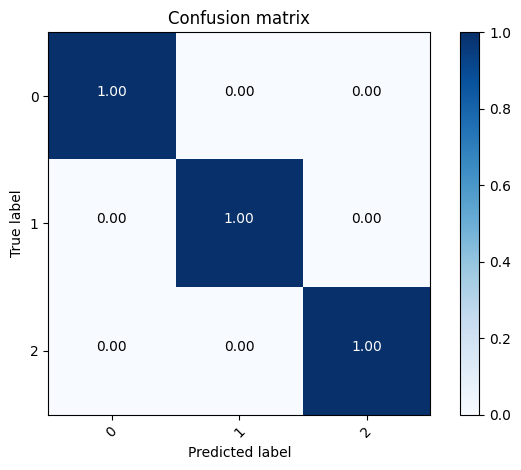

In [ ]:
plot_confusion_matrix(cm=confusion_matrix(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values),
                      classes=[0  ,1  ,2],
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)